# TM10007 Assignment template -- ECG data

## Data loading and cleaning

Below are functions to load the dataset of your choice. After that, it is all up to you to create and evaluate a classification method. Beware, there may be missing values in these datasets. Good luck!

Importing modules

In [200]:
import os
import zipfile
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
from sklearn import datasets as ds
import seaborn
import math
import statistics
import math
import matplotlib.pyplot as plt
from sklearn import datasets as ds
import seaborn

import numpy as np
from scipy.stats import shapiro 
from scipy.stats import lognorm
from scipy.spatial.distance import cdist


# Classifiers
from sklearn import model_selection
from sklearn import metrics
from sklearn import feature_selection 
from sklearn import preprocessing
from sklearn import neighbors
from sklearn import svm
from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier


cwd = os.getcwd() # This fn will return the Current Working Directory

zip_path = os.path.join(cwd, 'ecg', 'ecg_data.zip')
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(os.path.join(cwd, 'ecg'))

data_path = os.path.join(cwd, 'ecg', 'ecg_data.csv')
data = pd.read_csv(data_path, index_col=0)

Exploring data part 1
- How many people have a normal ECG?
- How many people have an abnormal ECG?

In [201]:
# split labels from data
x = data.loc[:, data.columns != 'label']  #alles behalve label
y = data['label']  # labels

# normal / abnormal ECGs
total_abnormal_ECG = np.count_nonzero(y)  # current dataset has 146 nonzeros
total_normal_ECG = y.size -np.count_nonzero(y)  # current dataset has 681 zeros
percentage_abnormal = total_abnormal_ECG / (total_abnormal_ECG + total_normal_ECG)*100  # 17.65 %


Splitting data into training and test data
- Subset training and test based on ratios
- Stratification
- Cross-validation?

In [203]:
# Split data
X_train, X_test_DO_NOT_FIT, y_train, y_test_DO_NOT_FIT = model_selection.train_test_split(x, y, test_size=0.25, stratify=y)
y_train_ab = y_train==1  # waarom maken we hier bools van? ipv 1 en 0 hebben we nu true en false
# X_test_DO_NOT_FIT and y_test_DO_NOT_FIT SHOULD NOT BE USED FOR FITTING!!

# Scale the data to be normal
scaler = preprocessing.RobustScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test_scaled_DO_NOT_FIT = scaler.transform(X_test_DO_NOT_FIT)

X_train=pd.DataFrame(X_train)
X_test_scaled_DO_NOT_FIT = pd.DataFrame(X_test_scaled_DO_NOT_FIT)

# Cross-validation
# cv_20fold = model_selection.StratifiedKFold(n_splits=10) --> uit college 1.2_generalization.ipyb

# Loop over the folds
#for validation_index, test_index in cv_20fold.split(X2, y2):
    # Split the data properly
#    X_validation = X2[validation_index]
#    y_validation = y2[validation_index]
    
#    X_test = X2[test_index]
#    y_test = y2[test_index]


Missing data
- Removing features if there is lot of data missing (replace all for a value)
- Removing samples (in this case patients) if there is a lot of data missing
- Imputation for generating data to fill us missing values -> median

In [ ]:
# Missing data
X_train = X_train.replace(0, np.nan)  # make all zeros to NaN
nan_count = X_train.isna().sum().sum()  # count missing data -> 10500 in our dataset

# Delete missing data when > --% of feature of sample is missing
X_train = X_train.dropna(axis='columns', how='all') # deletes a feature if all values of a column (so feature) are empty
X_train = X_train.dropna(axis='rows', how='all') # deletes a patient if all values of a row (so sample) are empty

# Missing data to median per feature
for column in X_train.columns:
    X_train[column].fillna(X_train[column].median(), inplace=True)

Exploring data part 2
- Is the data normally distributed?

In [213]:
# Normally distributed
stat = []
p = []
for col in X_train.columns:
    if X_train[col].dtype == 'float64' or X_train[col].dtype == 'int64':
        s, pv = shapiro(X_train[col])
        stat.append(s)
        p.append(pv)
    else:
        stat.append(None)
        p.append(None)

AttributeError: 'numpy.ndarray' object has no attribute 'columns'

Outliers
- Detect outliers using Z-score since data is not nornally distributed
- Replace outliers by the median of that feature
- Print -> check wether the outliers are changed

In [ ]:
# create a new dataframe to store the results
results = pd.DataFrame({'Column': X_train.columns, 'W': stat, 'p-value': p}) 
mean_p_value = results['p-value'].mean()  # p-value is really small. If p-value is bigger than 0.05, then data is normally distributed. SO its not
median_p_value = results['p-value'].median()  # p-value is really small. If p-value is bigger than 0.05, then data is normally distributed. SO its not

# Outliers: Tukey's fence 
k=3
fences=pd.DataFrame()
outliers = pd.DataFrame(False, index=X_train.index, columns=X_train.columns) # create an empty DataFrame for outliers

for col in X_train.columns:
    q1, q3 = np.percentile(X_train[col], [25, 75])
    iqr = q3 - q1
    lower_fence = q1 - k*iqr
    upper_fence = q3 + k*iqr
    fences[col]=[lower_fence, upper_fence]
    for row in X_train.index:
        if X_train.loc[row, col] < lower_fence or X_train.loc[row, col] > upper_fence:
            outliers.loc[row, col] = True # mark the place as an outlier

row_count = (outliers == True).sum(axis=1)
col_count = (outliers == True).sum(axis=0)
total_count = row_count.sum() + col_count.sum()
print(f'The total outliers in dataset x is {total_count}')

In [ ]:
# create a copy of x to modify
new_x = X_train.copy()

# replace outliers with median of x by column
for col in outliers.columns:
    median = X_train.loc[outliers[col] == False, col].median() # median of column where outlier is False
    new_x.loc[outliers[col], col] = median # replace outliers with median

In [ ]:
# Check wether there are still outliers or not
k=3
fences=pd.DataFrame()
outliers = pd.DataFrame(False, index=X_train.index, columns=X_train.columns) # create an empty DataFrame for outliers

for col in new_x.columns:
    q1, q3 = np.percentile(X_train[col], [25, 75])
    iqr = q3 - q1
    lower_fence = q1 - k*iqr
    upper_fence = q3 + k*iqr
    fences[col]=[lower_fence, upper_fence]
    for row in new_x.index:
        if new_x.loc[row, col] < lower_fence or new_x.loc[row, col] > upper_fence:
            outliers.loc[row, col] = True # mark the place as an outlier

row_count = (outliers == True).sum(axis=1)
col_count = (outliers == True).sum(axis=0)
total_count = row_count.sum() + col_count.sum()

print(f'total outliers of the filtered x is {total_count}')

In [ ]:
#change the x_train to the new_x
X_train = new_x

Feature selection:
- Remove features with zero variance

In [204]:
sel_vt = VarianceThreshold(threshold=0.0)
X_vt = sel_vt.fit_transform(X_train, y_train)
print(X_vt.shape)

(620, 9000)


PCA
- How many principal components? (n=2/3) --> to make plots visual
- Scree plot to determine amount of features to use?


In [205]:
# Reduce the number of features with PCA.
n_samples = X_train.shape[0]
n_features = X_train.shape[1]
n_features = min(n_samples, n_features)

pca = PCA(n_components=n_features)            
X_train = pca.fit_transform(X_train)

print(n_samples)
print(n_features)
print(pca.n_components_)

620
620
620


- Univariate

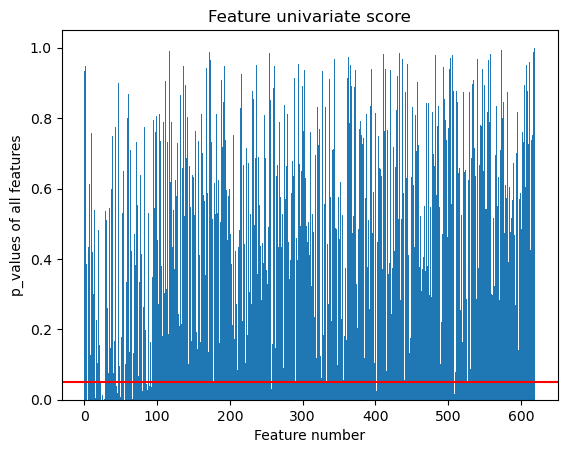

In [206]:
# selectKbest features 
sel_kb = SelectKBest(f_classif, k='all')        # we trainen selector wel met 620 best en daarna pakken we pas de p_waarden --> kan dat wel?
sel_kb.fit(X_train, y_train)                         # is het dan, omdat we alleen 'fit' doen en niet 'fit_transform' dat de k niet uitmaakt, omdat we X_train niet transformen, maar de 'empirical variances of X' nemen
p_values = sel_kb.pvalues_

# plot p-values of all features
X_indices = np.arange(X_train.shape[-1])
plt.figure(1)
plt.clf()
plt.bar(X_indices - 0.05, p_values, width=1)
plt.axhline(y=0.05, color='r', linestyle='-')
plt.title("Feature univariate score")
plt.xlabel("Feature number")
plt.ylabel('p_values of all features')
plt.show()


In [207]:
# select features with p_value =< 0.05
features_selected = np.array(np.where(p_values <= 0.05))
print(features_selected.shape)

# select significant features in training set
X_train = X_train[:,features_selected[0,:]]
print(X_train.shape)

(1, 28)
(620, 28)


Function to make 2D-colorplot

In [208]:
# def colorplot(clf, ax, x, y, h=100, precomputer=None):
#     '''
#     Overlay the decision areas as colors in an axes.
    
#     Input:
#         clf: trained classifier
#         ax: axis to overlay color mesh on
#         x: feature on x-axis
#         y: feature on y-axis
#         h(optional): steps in the mesh
#     '''
#     # Create a meshgrid the size of the axis
#     xstep = (x.max() - x.min() ) / 20.0
#     ystep = (y.max() - y.min() ) / 20.0
#     x_min, x_max = x.min() - xstep, x.max() + xstep
#     y_min, y_max = y.min() - ystep, y.max() + ystep
#     h = max((x_max - x_min, y_max - y_min))/h
#     xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
#                          np.arange(y_min, y_max, h))

#     features = np.c_[xx.ravel(), yy.ravel()]
#     if precomputer is not None:
#         if type(precomputer) is RBFSampler:
#             features = precomputer.transform(features)
#         elif precomputer is rbf_kernel:
#             features = rbf_kernel(features, X)
            
#     # Plot the decision boundary. For that, we will assign a color to each
#     # point in the mesh [x_min, x_max]x[y_min, y_max].
#     if hasattr(clf, "decision_function"):
#         Z = clf.decision_function(features)
#     else:
#         Z = clf.predict_proba(features)
#     if len(Z.shape) > 1:
#         Z = Z[:, 1]

Trying out some basic classifiers

In [209]:
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier

In [210]:
# fig = plt.figure(figsize=(8, 8))
# ax = fig.add_subplot(111)
# ax.set_title("Two informative features, one cluster per class",
#              fontsize='small')
# ax.scatter(X_train[:, 0], X_train[:, 1], marker='o', c=y_train,
#            s=25, edgecolor='k', cmap=plt.cm.Paired)
clf = LinearDiscriminantAnalysis()
clf = clf.fit(X_train, y_train)
y_pred = clf.predict(X_train)
# colorplot(clf, ax, X_train[:, 0], X_train[:, 1])
print("Number of mislabeled points out of a total %d points : %d" % (X_train.shape[0], (y_train != y_pred).sum()))


y_pred=clf.predict(X_train)

if hasattr(clf, 'predict_proba'):
    # The first column gives the probability for class = 0, so we take
    # the second which gives the probability class = 1:
    y_score = clf.predict_proba(X_train)[:, 1]
else:
     y_score = y_pred

auc = metrics.roc_auc_score(y_train, y_score)
accuracy=metrics.accuracy_score(y_train, y_pred)
F1=metrics.f1_score(y_train, y_pred)
precision=metrics.precision_score(y_train, y_pred)
recall=metrics.recall_score(y_train, y_pred)
# accuracy, AUC, f1score, precision, recall
print(type(clf))
print('Acc:' +str(accuracy))
print('AUC:' +str(auc))
print('F1:' +str(F1))
print('precision:' +str(precision))
print('recall:' +str(recall))


Number of mislabeled points out of a total 620 points : 66
<class 'sklearn.discriminant_analysis.LinearDiscriminantAnalysis'>
Acc:0.8935483870967742
AUC:0.8896569058690461
F1:0.6162790697674418
precision:0.8412698412698413
recall:0.48623853211009177


K-Neirest Neighbour classifier

In [211]:
k_list = [1, 3, 7]
from sklearn import neighbors

for k in k_list:
    clf_knn = neighbors.KNeighborsClassifier(n_neighbors=k)
    clf_knn.fit(X_train, y_train)

    # Test the classifier on the training data and plot
    score_train = clf_knn.score(X_train, y_train)

    # Test the classifier on the test data and plot
    # score_test = clf_knn.score(X_test_scaled_DO_NOT_FIT,y_test_DO_NOT_FIT)

# print(f'test score os {score_test}')
print(score_train)

0.8564516129032258


*Support Vector Machines* 
Altough Support Vector Machines are quite intuitive and easy to use, they have quite a lot of hyperparameters. One general and highly important parameter is the slack C, which defaults to 1.0 in scikit learn. The SVM in scikit-learn contains defaults for the linear, polynomial and radial basis function kernels, and has options for their specific hyperparameters. However, SVMs also accept manually constructed and precomputed kernels.

*KNeighbours Classifiers*
*Random forest*
*Kernels*

In [212]:
# Construct classifiers
svmlin = SVC(kernel='linear', gamma='scale')
svmrbf = SVC(kernel='rbf', gamma='scale')
svmpoly = SVC(kernel='poly', degree=3, gamma='scale')

clsfs = [KNeighborsClassifier(), RandomForestClassifier(), svmlin, svmpoly, svmrbf]



for clf in clsfs:
    clf.fit(X_train, y_train)
    y_pred = clf.predict(x)
    print(f'Misclassified: %d / %d % {((y != y_pred).sum(), x.shape[0])}' )

c:\Users\ellem\miniconda3\lib\site-packages\sklearn\base.py:402: UserWarning: X has feature names, but KNeighborsClassifier was fitted without feature names
  warnings.warn(


ValueError: X has 9000 features, but KNeighborsClassifier is expecting 28 features as input.